In [1]:
import os
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import cv2
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [2]:
fb_feat=np.load('/kaggle/input/vit-features/dino_feat.npy')
print(fb_feat.shape)

(112198, 768)


In [3]:
df=pd.read_csv('/kaggle/input/clahe-labels/labels_path.csv')
labels=df.drop(columns=['paths'])
labels[labels>1]=1
labels.shape

(112198, 12)

In [4]:
from sklearn.model_selection import train_test_split

# Initial split for test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    fb_feat, labels, test_size=0.3, random_state=42
)

# Split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42
)
print(X_train.shape,X_val.shape,X_test.shape,y_train.shape,y_val.shape,y_test.shape)

(62830, 768) (15708, 768) (33660, 768) (62830, 12) (15708, 12) (33660, 12)


In [5]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [6]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
import cupy as cp

# Define the parameter grid
param_grid = {
    'estimator__n_estimators': [100, 200],  # Reduced range for n_estimators
    'estimator__max_depth': [6, 9],  # Reduced depth values
    'estimator__learning_rate': [0.01, 0.2],  # Keep learning rates
    'estimator__subsample': [0.9, 1.0],  # Subsample options
    'estimator__colsample_bytree': [0.9, 1.0],  # Column sample options
}


# Create XGBoost classifier with GPU support
xgb_estimator = xgb.XGBClassifier(
    objective='binary:logistic',
    tree_method='hist',
    device='cuda'
)

# Create MultiOutputClassifier instance with XGBoost model inside
multilabel_model = MultiOutputClassifier(xgb_estimator)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=multilabel_model,
    param_grid=param_grid,
    cv=2,  # Number of folds in cross-validation
    scoring='accuracy',  # You can use other metrics depending on your problem
    verbose=2,  # Increase to see more details
    n_jobs=-1  # Use all available CPU cores
)

# Fit GridSearchCV
grid_search.fit(cp.array(X_train), y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on test data
print(f"Best parameters: {best_params}")
print('Accuracy on test data: {:.1f}%'.format(accuracy_score(y_test, best_model.predict(X_test))*100))

Fitting 2 folds for each of 32 candidates, totalling 64 fits
Best parameters: {'estimator__colsample_bytree': 1.0, 'estimator__learning_rate': 0.2, 'estimator__max_depth': 9, 'estimator__n_estimators': 200, 'estimator__subsample': 0.9}


/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [10:32:06] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


Accuracy on test data: 82.1%


In [7]:
preds=best_model.predict(X_test)

In [8]:
col=['AU1',
 'AU12',
 'AU15',
 'AU17',
 'AU2',
 'AU20',
 'AU25',
 'AU26',
 'AU4',
 'AU5',
 'AU6',
 'AU9']

In [9]:
preds.shape

(33660, 12)

METRICS FOR EACH ACTION UNIT :
AU1: ACCURACY = 0.99, F1 SCORE = 0.90
CLASSIFICATION REPORT :                precision    recall  f1-score   support

           0       0.99      1.00      0.99     31079
           1       0.96      0.84      0.90      2581

    accuracy                           0.99     33660
   macro avg       0.98      0.92      0.94     33660
weighted avg       0.98      0.99      0.98     33660

AU12: ACCURACY = 0.97, F1 SCORE = 0.95
CLASSIFICATION REPORT :                precision    recall  f1-score   support

           0       0.98      0.99      0.98     24398
           1       0.96      0.94      0.95      9262

    accuracy                           0.97     33660
   macro avg       0.97      0.96      0.96     33660
weighted avg       0.97      0.97      0.97     33660

AU15: ACCURACY = 0.99, F1 SCORE = 0.92
CLASSIFICATION REPORT :                precision    recall  f1-score   support

           0       0.99      1.00      0.99     31338
           1   

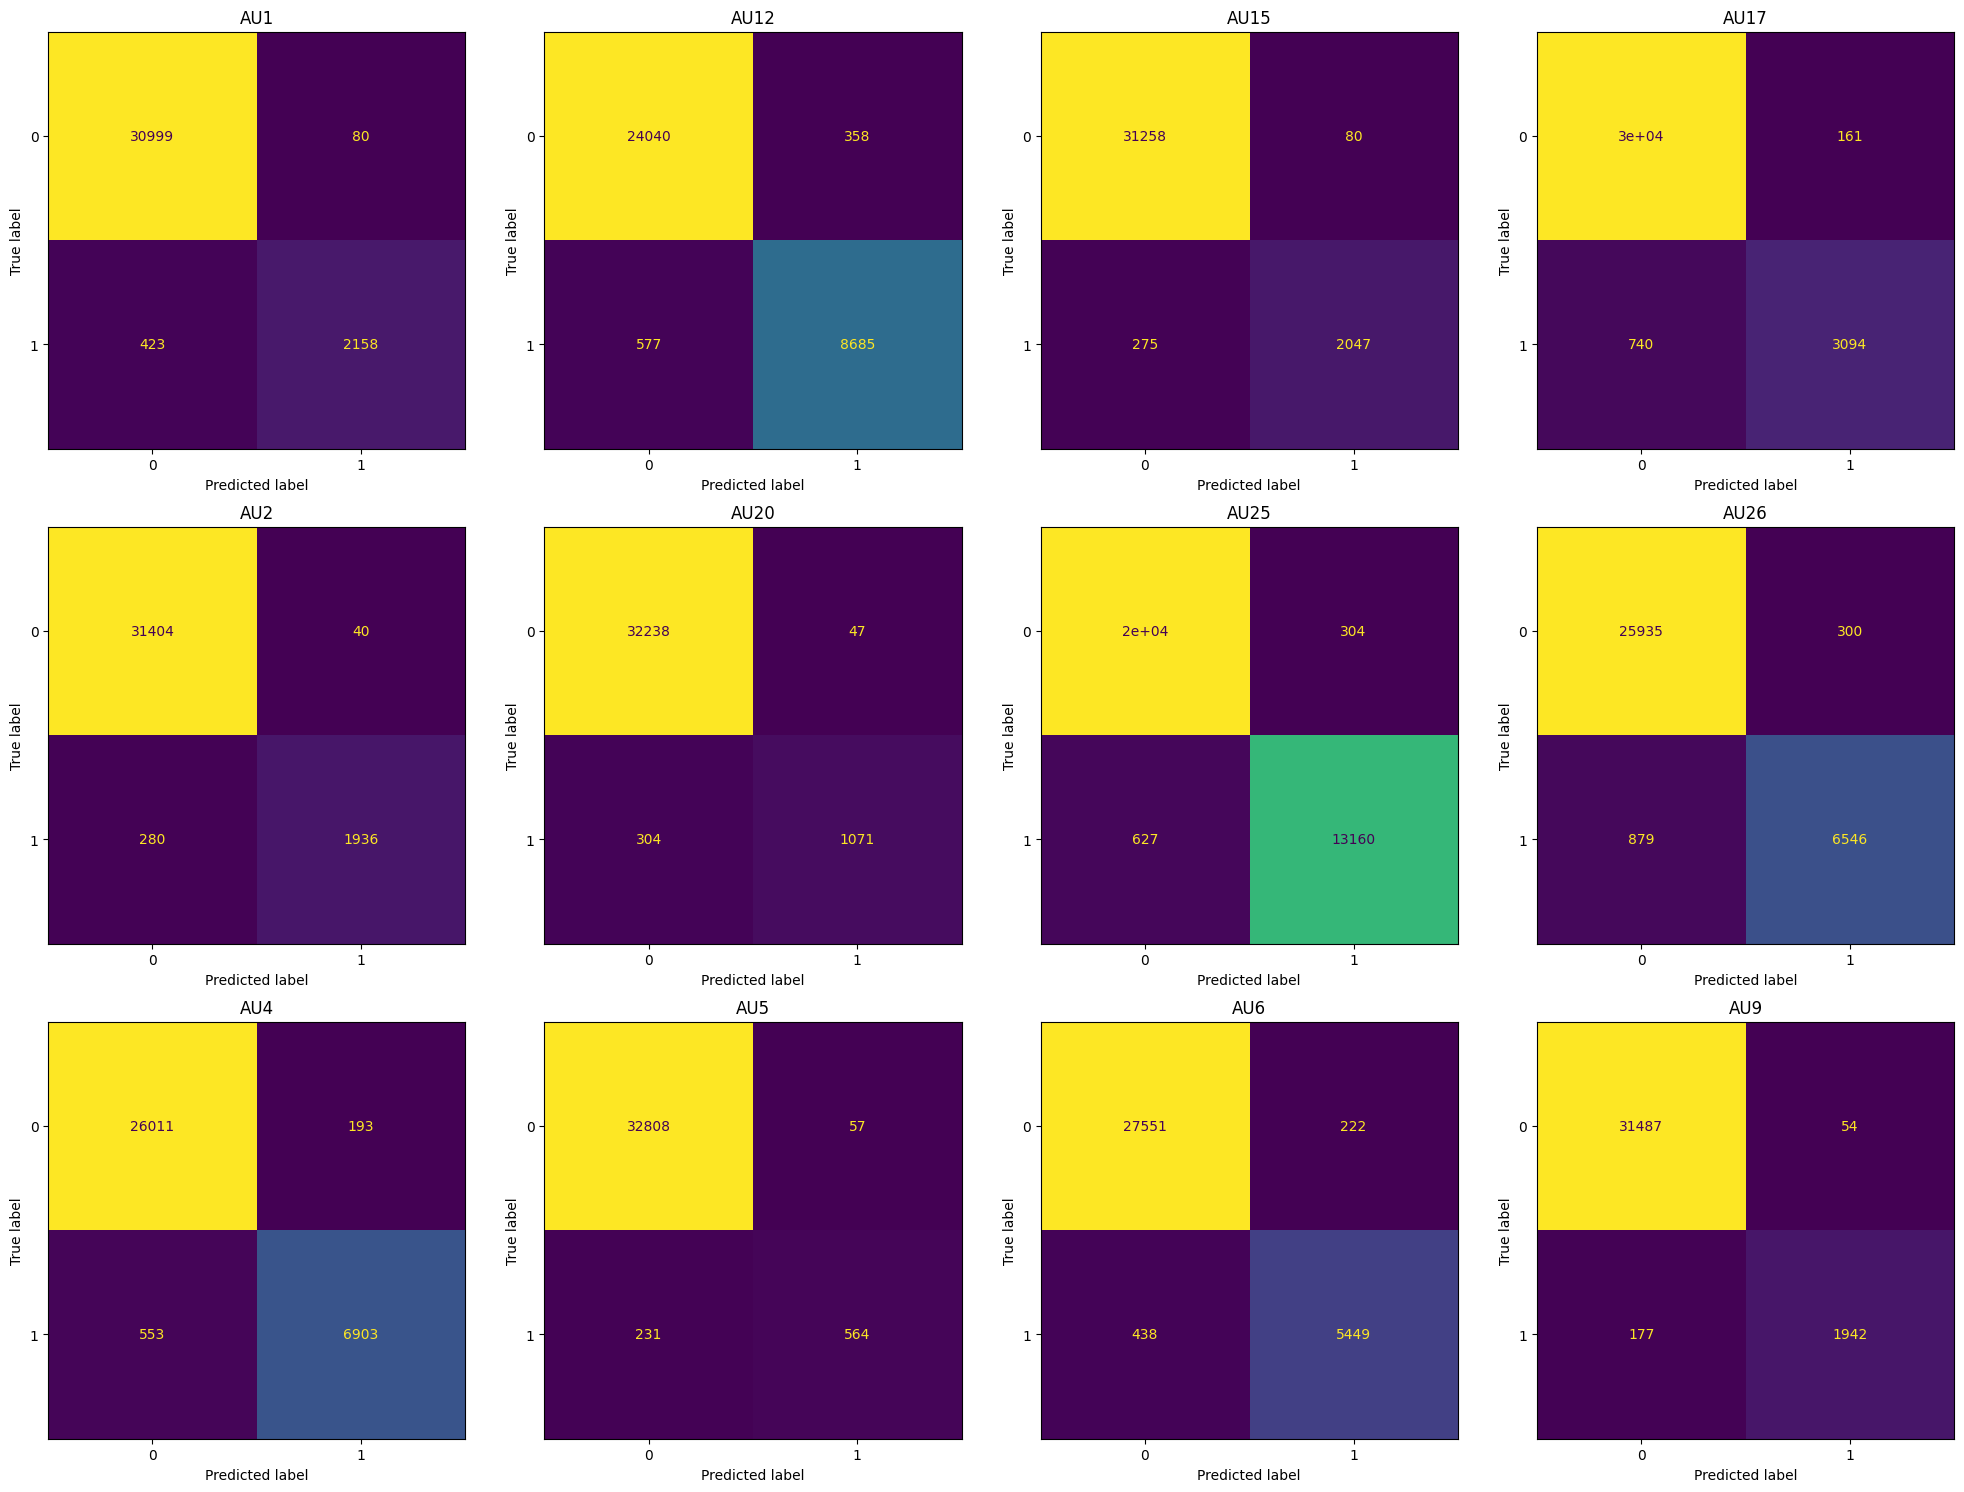

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score,classification_report

# Define action units and predictions
au = col
p = preds
test_labels = np.array(y_test)

# Create a subplot for confusion matrices
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

print("METRICS FOR EACH ACTION UNIT :")

for i in range(12):
    # Calculate accuracy
    accuracy = accuracy_score(test_labels[:, i], p[:, i])
    # Calculate F1 score
    f1 = f1_score(test_labels[:, i], p[:, i])
    
    print(f'{au[i]}: ACCURACY = {accuracy:.2f}, F1 SCORE = {f1:.2f}')
    print('CLASSIFICATION REPORT : ',classification_report(test_labels[:, i], p[:, i]))
    # Plot confusion matrix
    cm = confusion_matrix(test_labels[:, i], p[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], colorbar=False)
    axes[i].set_title(au[i])

# Adjust layout
plt.tight_layout()
plt.show()


In [11]:
import joblib

# Save the trained MultiOutputClassifier model
joblib.dump(best_model, 'xgb_multilabel_model.pkl')

['xgb_multilabel_model.pkl']